In [1]:
import json
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib import rc
import random

In [2]:
# matplotlib 한글 폰트 깨짐 문제 해결
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
fontprop = fm.FontProperties(fname=font_path)

In [9]:
# 경로 설정

data_path = '/workspace/Data_All/'

img_path = data_path + 'image/'                     # /workspace/Data_All/image/
json_path = data_path + 'label/'                    # /workspace/Data_All/label/
segment_path = data_path + 'segmentation/'          # /workspace/Data_All/segmentation/

happy_img_path = img_path + 'happy'                 # /workspace/Data_All/image/happy/

In [4]:
# 라벨 정보 json 파일 (train, val, test 파일 통합)
# train_happy.json + val_happy.json + test_happy.json -> json_happy

# json 파일 각각 불러오기
with open (json_path + "train_happy.json", "r", encoding='euc-kr') as f:
    json_happy_train = json.load(f)
with open (json_path + "val_happy.json", "r", encoding='euc-kr') as f:
    json_happy_val = json.load(f)
with open (json_path + "test_happy.json", "r", encoding='euc-kr') as f:
    json_happy_test = json.load(f)

# 하나의 파일로 통합
json_happy = []
if isinstance(json_happy_train, list):
    json_happy.extend(json_happy_train)
if isinstance(json_happy_val, list):
    json_happy.extend(json_happy_val)
if isinstance(json_happy_test, list):
    json_happy.extend(json_happy_test)

In [5]:
len(json_happy)     # 1494(train) + 300(val) + 300(test) = 2094

2094

In [11]:
# 이미지와 json 파일 내 이름이 일치하는지 확인

IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count

image_count = count_images_in_folder(happy_img_path)
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_happy)}")
print()

# 폴더 내 이미지 파일 이름 수집
def get_image_files_in_folder(folder_path):
    image_files = set()
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_files.add(file)
    return image_files

# JSON 파일 내 이미지 파일 이름 수집
def get_image_files_in_json(json_file):
    json_filenames = {entry["filename"] for entry in json_file}
    return json_filenames

# 비교 수행
image_files_in_folder = get_image_files_in_folder(happy_img_path)
image_files_in_json = get_image_files_in_json(json_happy)

# 누락된 파일 찾기
missing_in_json = image_files_in_folder - image_files_in_json
missing_in_folder = image_files_in_json - image_files_in_folder

# 결과 출력 
print(f"JSON 파일에 없는 폴더 내 이미지 파일: {missing_in_json}")
print(f"폴더에 없는 JSON 파일의 이미지 파일: {missing_in_folder}")

폴더 내 이미지 파일 개수: 2094
json 파일 길이 : 2094

JSON 파일에 없는 폴더 내 이미지 파일: set()
폴더에 없는 JSON 파일의 이미지 파일: set()


In [12]:
json_happy[0]

{'filename': '1ssf46b4695747c6e323bf090389b57049cff58a0851d50d3de8c0dc5ccb7lemg.jpg',
 'gender': '남',
 'age': 50,
 'isProf': '일반인',
 'faceExp_uploader': '기쁨',
 'bg_uploader': '실외 자연환경',
 'annot_A': {'boxes': {'maxX': 2080.465,
   'maxY': 1655.1898000000003,
   'minX': 1383.6719000000003,
   'minY': 719.3847},
  'faceExp': '기쁨',
  'bg': '실외 자연환경'},
 'annot_B': {'boxes': {'maxX': 2080.4649999999997,
   'maxY': 1722.081477143965,
   'minX': 1383.6719000000003,
   'minY': 815.2268358056745},
  'faceExp': '기쁨',
  'bg': '실외 자연환경'},
 'annot_C': {'boxes': {'maxX': 2080.465,
   'maxY': 1655.1898000000003,
   'minX': 1383.6719,
   'minY': 719.3847000000001},
  'faceExp': '기쁨',
  'bg': '실외 자연환경'}}

In [13]:
# Json 파일 -> DataFrame 변환
# df_happy

# 데이터 변환 함수 정의
def process_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # annot_A, annot_B, annot_C 데이터 추가
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            row = {
                **base_info,
                'annot': annot_key,
                'faceExp': annot.get('faceExp'),
                'bg': annot.get('bg'),
                'minX': annot.get('boxes', {}).get('minX'),
                'minY': annot.get('boxes', {}).get('minY'),
                'maxX': annot.get('boxes', {}).get('maxX'),
                'maxY': annot.get('boxes', {}).get('maxY'),
            }
            processed_data.append(row)
    return pd.DataFrame(processed_data)

# 데이터프레임 생성
df_happy = process_data(json_happy)

In [14]:
df_happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6282 entries, 0 to 6281
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          6282 non-null   object 
 1   gender            6282 non-null   object 
 2   age               6282 non-null   int64  
 3   isProf            6282 non-null   object 
 4   faceExp_uploader  6282 non-null   object 
 5   bg_uploader       6282 non-null   object 
 6   annot             6282 non-null   object 
 7   faceExp           6282 non-null   object 
 8   bg                6282 non-null   object 
 9   minX              6282 non-null   float64
 10  minY              6282 non-null   float64
 11  maxX              6282 non-null   float64
 12  maxY              6282 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 638.1+ KB


In [15]:
df_happy

filename gender  age isProf  \
0     1ssf46b4695747c6e323bf090389b57049cff58a0851d5...      남   50    일반인   
1     1ssf46b4695747c6e323bf090389b57049cff58a0851d5...      남   50    일반인   
2     1ssf46b4695747c6e323bf090389b57049cff58a0851d5...      남   50    일반인   
3     hfbl2d0622517ad6ef5456d1fa4e7d52f57ff1dff32094...      남   20    일반인   
4     hfbl2d0622517ad6ef5456d1fa4e7d52f57ff1dff32094...      남   20    일반인   
...                                                 ...    ...  ...    ...   
6277  pn665886474bd146cdc417ed31c070040073ecd90c4c8b...      남   40    전문인   
6278  pn665886474bd146cdc417ed31c070040073ecd90c4c8b...      남   40    전문인   
6279  jtl0fdd55e8a037f238ce20faf8853572f4dfaa4e27a68...      여   30    전문인   
6280  jtl0fdd55e8a037f238ce20faf8853572f4dfaa4e27a68...      여   30    전문인   
6281  jtl0fdd55e8a037f238ce20faf8853572f4dfaa4e27a68...      여   30    전문인   

     faceExp_uploader bg_uploader    annot faceExp          bg         minX  \
0                  기쁨     실외 자연환경  annot_A      기쁨     실외 자연환경  1383.671900   
1                  기쁨     실외 자연환경  annot_B      기쁨     실외 자연환경  1383.671900   
2                  기쁨     실외 자연환경  annot_C      기쁨     실외 자연환경  1383.671900   
3                  기쁨     실외 자연환경  annot_A      기쁨     실외 자연환경   471.411790   
4                  기쁨     실외 자연환경  annot_B      기쁨     실외 자연환경   471.302790   
...               ...         ...      ...     ...         ...          ...   
6277               기쁨     오락/공연시설  annot_B      기쁨     오락/공연시설   453.884271   
6278               기쁨     오락/공연시설  annot_C      기쁨  상업시설/점포/시장   452.596300   
6279               기쁨     행사/사무공간  annot_A      기쁨     행사/사무공간  1023.234900   
6280               기쁨     행사/사무공간  annot_B      기쁨     행사/사무공간  1023.368274   
6281               기쁨     행사/사무공간  annot_C      기쁨     행사/사무공간  1023.234900   

            minY         maxX         maxY  
0     719.384700  2080.465000  1655.189800  
1     815.226836  2080.465000  1722.081477  
2     719.384700  2080.465000  1655.189800  
3     277.346133   937.669830   822.907783  
4     279.082133   937.193830   820.576784  
...          ...          ...          ...  
6277  171.253197   942.784527   870.076726  
6278  160.913210   952.256040   843.968570  
6279  156.163730  1746.587400  1186.201300  
6280  180.662628  1774.492121  1200.254783  
6281  156.163730  1746.587400  1186.201300  

[6282 rows x 13 columns]

##### 표정 데이터 확인
- faceExp_uploader (image) 와 faceExp (annot) 차이 확인
- 표정 정보가 다른 이미지들 어떻게 처리할지

In [16]:
df_happy['faceExp_uploader'].value_counts()


faceExp_uploader
기쁨    6282
Name: count, dtype: int64

In [17]:
df_happy['faceExp'].value_counts()

faceExp
기쁨    6098
중립      65
당황      48
불안      26
슬픔      21
분노      12
상처      12
Name: count, dtype: int64

In [18]:
# faceExp가 기쁨이 아닌 데이터 추출
def process_non_happy_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # Process each annotation and filter for non-happy faceExp
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            face_exp = annot.get('faceExp')
            if face_exp != "기쁨":  # Only include non-happy faceExp
                row = {
                    **base_info,
                    'annot': annot_key,
                    'faceExp': face_exp,
                    'bg': annot.get('bg'),
                    'minX': annot.get('boxes', {}).get('minX'),
                    'minY': annot.get('boxes', {}).get('minY'),
                    'maxX': annot.get('boxes', {}).get('maxX'),
                    'maxY': annot.get('boxes', {}).get('maxY'),
                }
                processed_data.append(row)
    return pd.DataFrame(processed_data)

df_not_happy = process_non_happy_data(json_happy)

In [19]:
df_not_happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          184 non-null    object 
 1   gender            184 non-null    object 
 2   age               184 non-null    int64  
 3   isProf            184 non-null    object 
 4   faceExp_uploader  184 non-null    object 
 5   bg_uploader       184 non-null    object 
 6   annot             184 non-null    object 
 7   faceExp           184 non-null    object 
 8   bg                184 non-null    object 
 9   minX              184 non-null    float64
 10  minY              184 non-null    float64
 11  maxX              184 non-null    float64
 12  maxY              184 non-null    float64
dtypes: float64(4), int64(1), object(8)
memory usage: 18.8+ KB


In [20]:
df_not_happy

filename gender  age isProf  \
0    1xvo29f24267fc0d2fa7c194983e124284f92860226356...      남   30    전문인   
1    gfogd47a7255637552b1f3d662459579f1e947076af25f...      남   30    전문인   
2    gfogd47a7255637552b1f3d662459579f1e947076af25f...      남   30    전문인   
3    gfogd47a7255637552b1f3d662459579f1e947076af25f...      남   30    전문인   
4    lfc5dd549ddbf0dbc4f9b355d18d6d8891014f05461c83...      여   30    전문인   
..                                                 ...    ...  ...    ...   
179  swr9c3c186cb6050a61fe6764c847ef0f1ed7c207bcd26...      남   30    전문인   
180  xh7k733d21c9dd5352f33d5f3e45563a53b8a41baa59ad...      여   30    일반인   
181  zg8mab537faeb3aaf315b342e5b4e7289ca883875cb408...      여   30    전문인   
182  78mxbbeee909ebe9edef09d924428f0ebf16ff5407a2cf...      남   20    일반인   
183  78mxbbeee909ebe9edef09d924428f0ebf16ff5407a2cf...      남   20    일반인   

    faceExp_uploader bg_uploader    annot faceExp             bg         minX  \
0                 기쁨     오락/공연시설  annot_A      당황  스포츠 관람 및 레저시설   894.132900   
1                 기쁨  상업시설/점포/시장  annot_A      당황     상업시설/점포/시장   935.071200   
2                 기쁨  상업시설/점포/시장  annot_B      분노     상업시설/점포/시장   969.943359   
3                 기쁨  상업시설/점포/시장  annot_C      분노     상업시설/점포/시장   962.891854   
4                 기쁨     오락/공연시설  annot_C      당황        오락/공연시설  1304.680581   
..               ...         ...      ...     ...            ...          ...   
179               기쁨     행사/사무공간  annot_C      슬픔     공공시설/종교/의료  1198.509231   
180               기쁨   숙박 및 거주공간  annot_A      불안          도심 환경  1434.983112   
181               기쁨  상업시설/점포/시장  annot_C      불안     상업시설/점포/시장  1592.651700   
182               기쁨       도심 환경  annot_A      당황          도심 환경   427.933234   
183               기쁨       도심 환경  annot_C      분노     상업시설/점포/시장   417.473483   

           minY         maxX         maxY  
0    373.212220  1509.734400  1137.536100  
1    351.817720  1531.981000  1105.139500  
2    385.762500  1547.068359  1157.287500  
3    352.012579  1547.233881  1163.269507  
4    505.892932  2118.496018  1702.316670  
..          ...          ...          ...  
179  519.700227  2057.452343  1804.218276  
180  224.604280  2364.230137  1439.229781  
181  795.662500  2388.834700  1928.816800  
182  628.118021  1467.640208  1880.670521  
183  615.798001  1482.753083  1868.350501  

[184 rows x 13 columns]

In [21]:
df_not_happy['faceExp'].value_counts()

faceExp
중립    65
당황    48
불안    26
슬픔    21
분노    12
상처    12
Name: count, dtype: int64

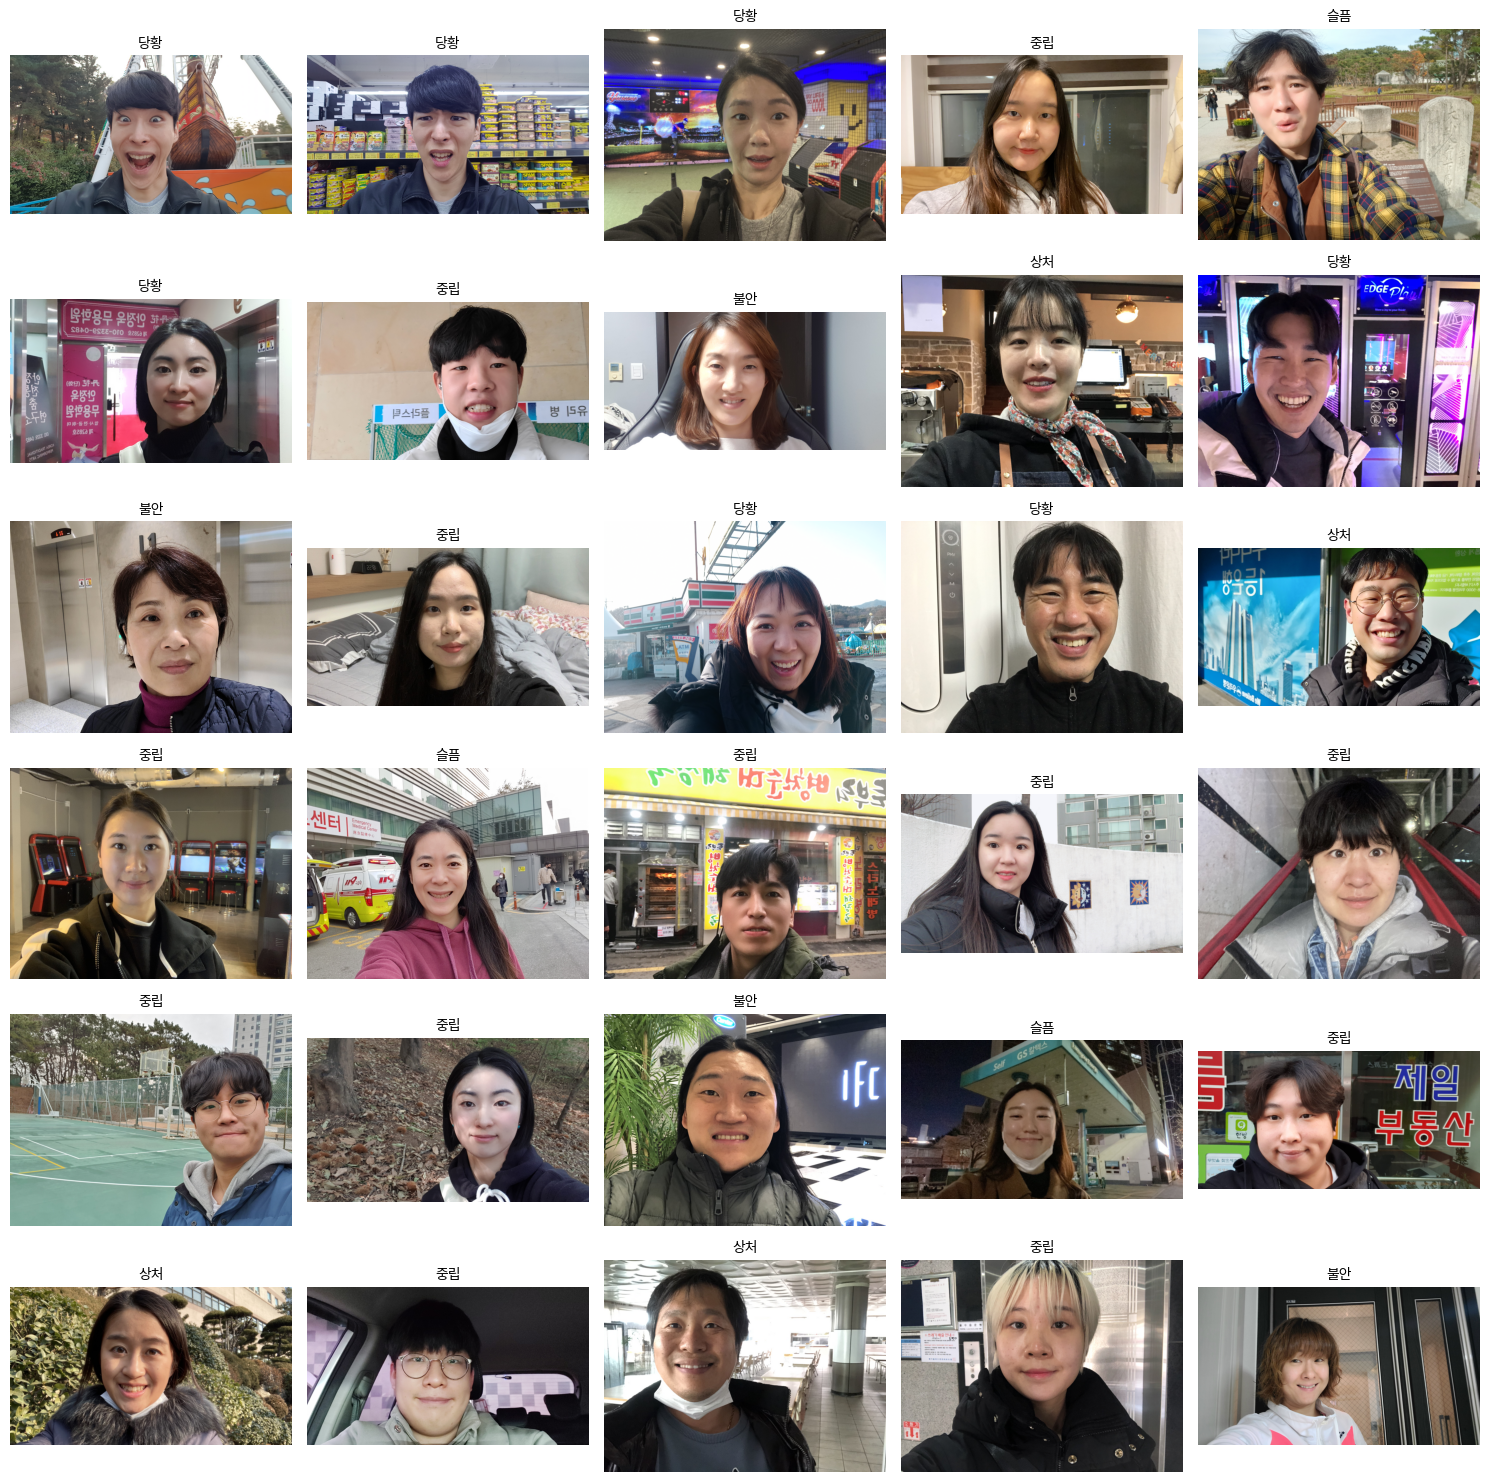

In [22]:
# 감정 정보가 다른 이미지 시각화
unique_filenames = df_not_happy['filename'].unique()

plt.figure(figsize=(15, 15))

for i, filename in enumerate(unique_filenames):
    if i >= 30:  # Show only the first 30 images for this example
        break
    image_path = os.path.join(happy_img_path, filename)
    if os.path.exists(image_path):  # Ensure the file exists
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(6, 5, i + 1)
        plt.imshow(image)
        faceExp = df_not_happy[df_not_happy['filename'] == filename]['faceExp'].iloc[0]
        plt.title(faceExp, fontproperties=fontprop)
        plt.axis('off')

plt.tight_layout()
plt.show()

##### 연령, 성별, 전문인 column 분포 확인

In [23]:
# 연령 분포 확인
df_happy['age'].value_counts(), df_happy['age'].value_counts(normalize=True)

(age
 20    3141
 30    2229
 40     621
 50     183
 10      81
 60      27
 Name: count, dtype: int64,
 age
 20    0.500000
 30    0.354823
 40    0.098854
 50    0.029131
 10    0.012894
 60    0.004298
 Name: proportion, dtype: float64)

In [24]:
# 성별 분포 확인
df_happy['gender'].value_counts(), df_happy['gender'].value_counts(normalize=True)

(gender
 여    3420
 남    2862
 Name: count, dtype: int64,
 gender
 여    0.544413
 남    0.455587
 Name: proportion, dtype: float64)

In [25]:
# 전문인 여부
df_happy['isProf'].value_counts(), df_happy['isProf'].value_counts(normalize=True)

(isProf
 일반인    3405
 전문인    2877
 Name: count, dtype: int64,
 isProf
 일반인    0.542025
 전문인    0.457975
 Name: proportion, dtype: float64)

##### 배경 정보 확인
- bg_uploader와 bg 차이 확인
- 배경 정보가 다른 이미지들 어떻게 처리할지

In [26]:
# 배경 정보
df_happy['bg_uploader'].value_counts(), df_happy['bg'].value_counts()

(bg_uploader
 숙박 및 거주공간            1170
 상업시설/점포/시장           1017
 공공시설/종교/의료시설          801
 도심 환경                 726
 실외 자연환경               687
 교통/이동수단(엘리베이터 포함)     672
 문화재 및 유적지             336
 스포츠 관람 및 레저시설         294
 오락/공연시설               291
 행사/사무공간               288
 Name: count, dtype: int64,
 bg
 숙박 및 거주공간            1204
 상업시설/점포/시장           1102
 공공시설/종교/의료            934
 도심 환경                 773
 실외 자연환경               644
 교통/이동수단(엘리베이터 포함)     580
 행사/사무공간               376
 오락/공연시설               235
 스포츠 관람 및 레저시설         211
 문화재 및 유적지             172
 공공시설/종교/의료시설           51
 Name: count, dtype: int64)

##### 박스 좌표 정보 확인
- 한 이미지 내 박스 좌표가 유사한지 시각화 및 좌표 수치 확인

In [27]:
# 박스 A,B,C의 좌표 차이가 일정 수치 이상인 데이터 검출

# 차이 확인 함수
def is_significant_difference(boxA, boxB, boxC, threshold):
    def box_difference(box1, box2):
        return sum(abs(box1[key] - box2[key]) for key in box1)
    
    diff_AB = box_difference(boxA, boxB)
    diff_BC = box_difference(boxB, boxC)
    diff_CA = box_difference(boxC, boxA)
    
    return max(diff_AB, diff_BC, diff_CA) > threshold

# 유사하지 않은 데이터를 저장할 리스트
outlier_filenames = []

# 박스 좌표 분석
thershold = 500

for entry in json_happy:
    annot_A = entry['annot_A']['boxes']
    annot_B = entry['annot_B']['boxes']
    annot_C = entry['annot_C']['boxes']
    
    if is_significant_difference(annot_A, annot_B, annot_C, thershold):
        outlier_filenames.append(entry['filename'])

# 결과 출력
print(f"outlier 파일 수:{len(outlier_filenames)}")

# outlier 데이터 추출 (json)
def extract_outliers(data, outlier_filenames):
    return [entry for entry in data if entry['filename'] in outlier_filenames]

outlier_json_happy = extract_outliers(json_happy, outlier_filenames)

outlier 파일 수:11


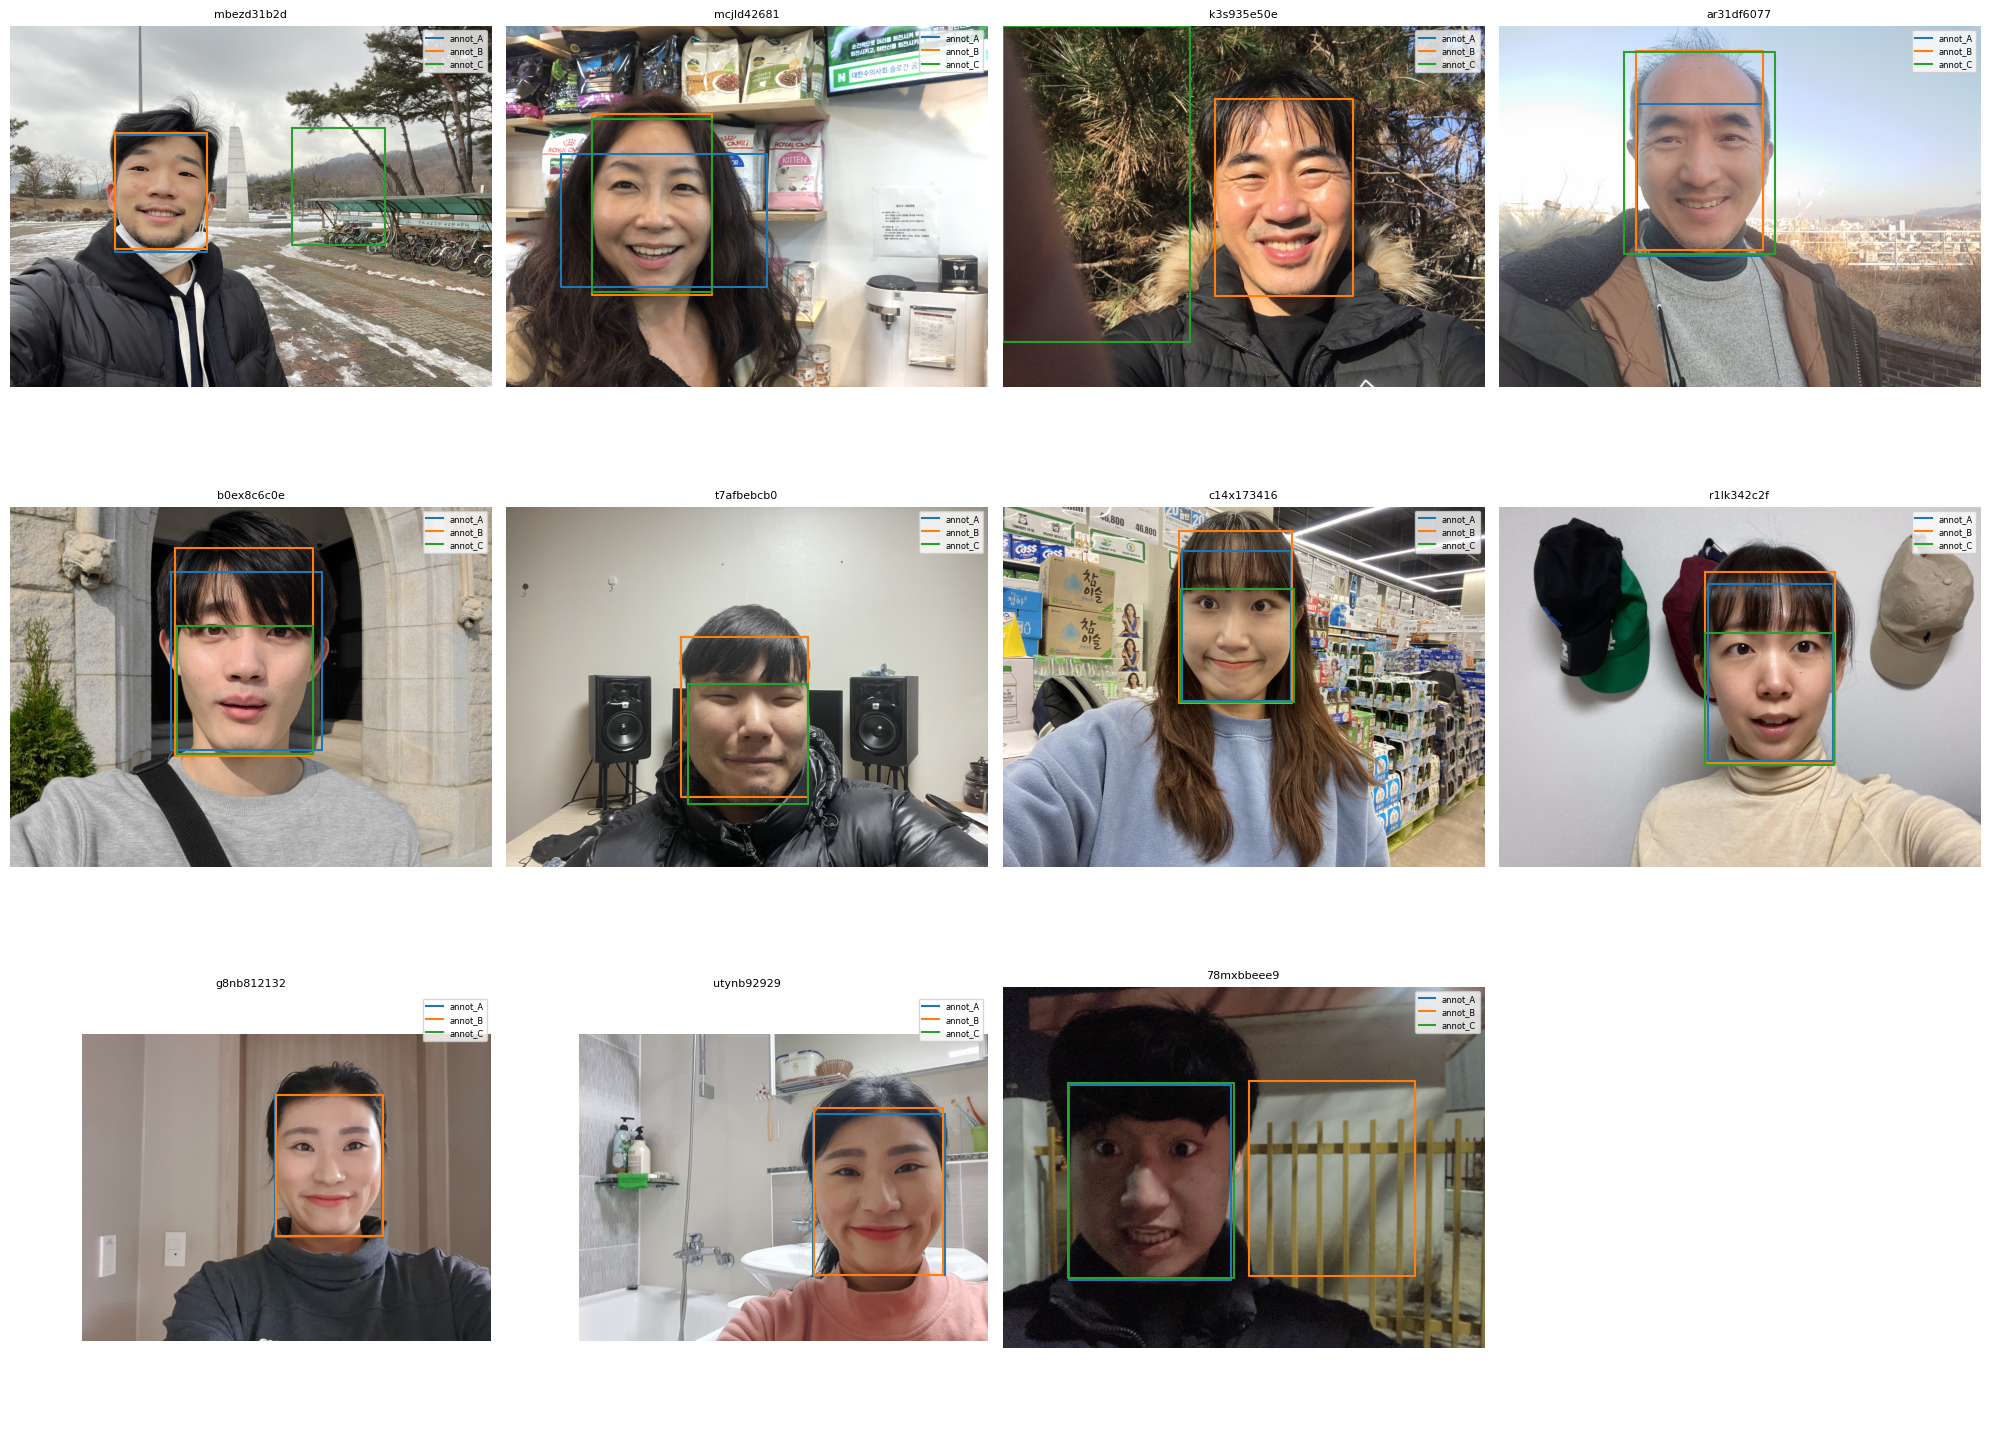

In [28]:
# outlier 시각화

# 이미지,박스 시각화 함수 정의
def visualize_boxes(data, image_dir):
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()

    for idx, item in enumerate(data):
        filename = item['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            continue

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image) 
        axes[idx].axis('off')

        # Plot boxes from annotations
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            if annot_key in item:
                box = item[annot_key]['boxes']
                x = [box['minX'], box['maxX'], box['maxX'], box['minX'], box['minX']]
                y = [box['minY'], box['minY'], box['maxY'], box['maxY'], box['minY']]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)
       
    # Hide unused subplots
    for i in range(len(data), 12):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
visualize_boxes(outlier_json_happy, happy_img_path)

In [31]:
# outlier 데이터 좌표 출력

def format_boxes(box):
    return {key: round(value, 2) for key, value in box.items()}

def print_outlier_coordinates(outlier_data):
    for i, entry in enumerate(outlier_data):
        print(f"Outlier {i+1}:")
        print(f"Filename: {entry['filename']}")
        print(f"  annot_A: {format_boxes(entry['annot_A']['boxes'])}")
        print(f"  annot_B: {format_boxes(entry['annot_B']['boxes'])}")
        print(f"  annot_C: {format_boxes(entry['annot_C']['boxes'])}")
        print("-" * 50)

print_outlier_coordinates(outlier_json_happy)

Outlier 1:
Filename: mbezd31b2d54ff4cc87290207fbe33ee4a7afe5344a788fe87cbce4fb8b1c4y2l.jpg
  annot_A: {'maxX': 1651.18, 'maxY': 1889.88, 'minX': 876.66, 'minY': 914.05}
  annot_B: {'maxX': 1646.67, 'maxY': 1867.8, 'minX': 882.99, 'minY': 891.98}
  annot_C: {'maxX': 3137.66, 'maxY': 1831.33, 'minX': 2363.14, 'minY': 855.5}
--------------------------------------------------
Outlier 2:
Filename: mcjld42681ab084d7243371ac8345626dc48d6b2615aa8804b573cbc74e4fw7x2.jpg
  annot_A: {'maxX': 1669.7, 'maxY': 1676.98, 'minX': 353.75, 'minY': 819.65}
  annot_B: {'maxX': 1319.11, 'maxY': 1726.24, 'minX': 550.93, 'minY': 568.48}
  annot_C: {'maxX': 1319.11, 'maxY': 1706.61, 'minX': 550.93, 'minY': 600.47}
--------------------------------------------------
Outlier 3:
Filename: k3s935e50e666fee414ce63c6a7cc0563dbee792014b083a74cbcbf602b735rqt.jpg
  annot_A: {'maxX': 1004.93, 'maxY': 1691.06, 'minX': 0, 'minY': 0}
  annot_B: {'maxX': 1877.13, 'maxY': 1443.41, 'minX': 1137.49, 'minY': 391.83}
  annot_C: {